<a href="https://colab.research.google.com/github/ShivanshPanwar/House-Price-Prediction/blob/main/HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ---- 1. Core Python Libraries ----
import os
import math
import warnings
from datetime import datetime

# Data Handling & Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
from IPython.display import display

# ---- 2. Statistical Analysis & Feature Engineering ----
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- 3. Machine Learning Models ----
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet
)
from sklearn.ensemble import RandomForestRegressor  # <-- Classifier corrected to Regressor

# ---- 4. Model Evaluation ----
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)

# ---- 5. Visualization Settings ----
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

# ---- 6. Warnings ----
warnings.filterwarnings("ignore")


In [3]:
# ============================
# 2. Load and Inspect Dataset
# ============================

# Load dataset (update path if necessary)
data_path = "/content/archive.zip"
housing_df = pd.read_csv(data_path)

# Display first few records
display(housing_df.head())

# Define target and feature columns
target_col = "price"
feature_cols = [col for col in housing_df.columns if col != target_col]

# Keep an untouched copy of raw dataset
raw_df = housing_df.copy()

# Print dataset information
print(f"\n\033[1mDataset Summary:\033[0m")
print(f"→ Total Samples: {housing_df.shape[0]}")
print(f"→ Total Features: {housing_df.shape[1] - 1} (excluding target column)")
print(f"→ Target Variable: {target_col}")


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Dataset Summary:
→ Total Samples: 545
→ Total Features: 12 (excluding target column)
→ Target Variable: price


In [5]:
# ============================
# 3. Dataset Overview
# ============================

# Check data types and non-null counts
print("\n\033[1mData Types & Non-Null Counts:\033[0m")
housing_df.info()

# Quick check for missing values
print("\n\033[1mMissing Values per Column:\033[0m")
print(housing_df.isnull().sum())

# Basic statistical summary
print("\n\033[1mStatistical Summary (Numerical Features):\033[0m")
display(housing_df.describe().T)



Data Types & Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB

Missing Values per Column:
price               0
area                0
bedrooms            0
bathrooms           0
stories

,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,1.0,3.0


In [6]:
# ============================
# 4. Unique Values & Feature Types
# ============================

# Count unique values in each feature
unique_counts = housing_df[feature_cols].nunique().sort_values()

# Separate categorical vs numerical features
cat_features, num_features = [], []
for col, count in unique_counts.items():
    if count <= 16:   # threshold for categorical
        cat_features.append(col)
    else:
        num_features.append(col)

# Print results
print(f"\n\033[1mFeature Classification:\033[0m")
print(f"→ Numerical Features: {len(num_features)}")
print(f"→ Categorical Features: {len(cat_features)}")
print(f"\nCategorical Columns: {cat_features}")
print(f"Numerical Columns: {num_features}")



Feature Classification:
→ Numerical Features: 1
→ Categorical Features: 11

Categorical Columns: ['hotwaterheating', 'basement', 'guestroom', 'mainroad', 'prefarea', 'airconditioning', 'furnishingstatus', 'bathrooms', 'stories', 'parking', 'bedrooms']
Numerical Columns: ['area']


In [7]:
# ============================
# 5. Statistical Summary
# ============================

# Generate descriptive statistics for numerical features
summary_stats = housing_df.describe().T  # Transposed for better readability

# Add extra info: missing values & data types
summary_stats["missing_values"] = housing_df.isnull().sum()
summary_stats["dtype"] = housing_df.dtypes

# Display summary
print("\n\033[1mDescriptive Statistics:\033[0m")
display(summary_stats)



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max,missing_values,dtype
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0,0,int64
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0,0,int64
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0,0,int64
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0,0,int64
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0,0,int64
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,1.0,3.0,0,int64


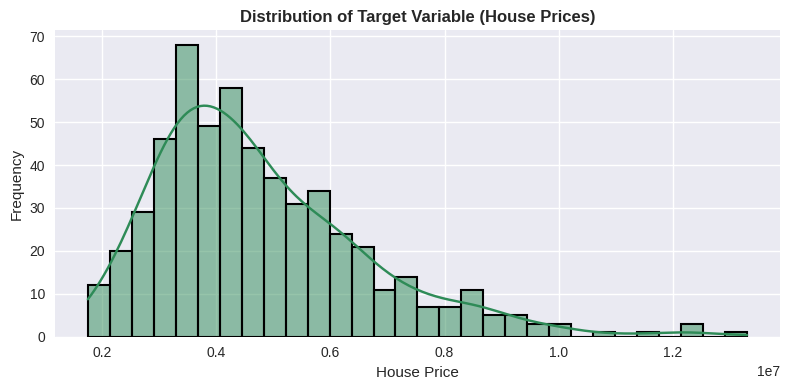


Target Summary:
→ Mean: 4766729.25
→ Median: 4340000.00
→ Std Dev: 1870439.62


In [8]:
# ============================
# 6. Target Variable Distribution
# ============================

plt.figure(figsize=(8, 4))
sns.histplot(
    housing_df[target_col],
    bins=30,
    kde=True,
    color="seagreen",
    edgecolor="black",
    linewidth=1.5
)
plt.title("Distribution of Target Variable (House Prices)", fontsize=12, fontweight="bold")
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"\n\033[1mTarget Summary:\033[0m")
print(f"→ Mean: {housing_df[target_col].mean():.2f}")
print(f"→ Median: {housing_df[target_col].median():.2f}")
print(f"→ Std Dev: {housing_df[target_col].std():.2f}")




                   Categorical Feature Distributions                    


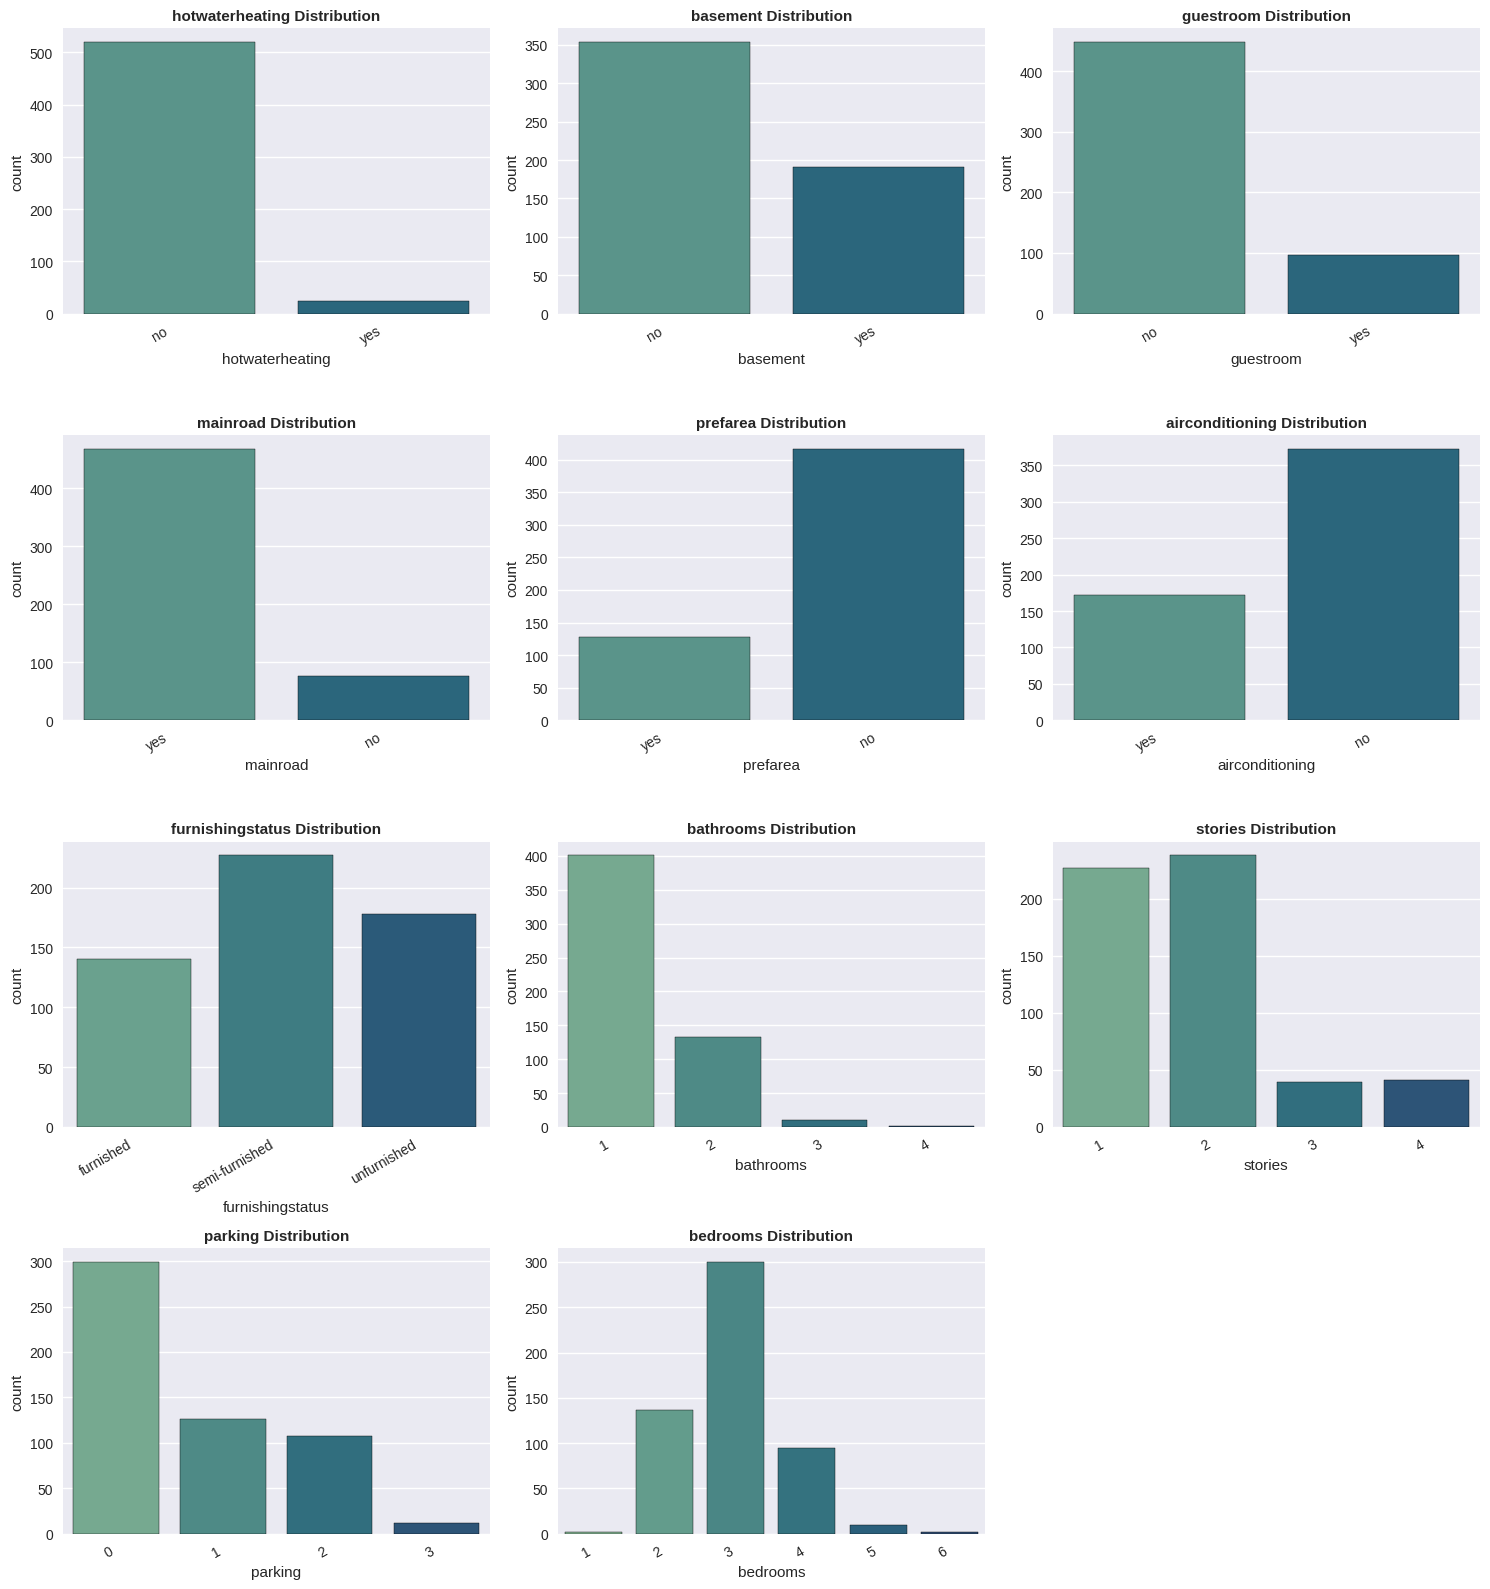

In [9]:
# ============================
# 7. Visualizing Categorical Features
# ============================

print("\n" + "\033[1mCategorical Feature Distributions\033[0m".center(80))

# Number of plots per row
plots_per_row = 3
rows = math.ceil(len(cat_features) / plots_per_row)

plt.figure(figsize=(15, 4 * rows))

for idx, col in enumerate(cat_features, 1):
    plt.subplot(rows, plots_per_row, idx)
    sns.countplot(
        data=housing_df,
        x=col,
        palette="crest",
        edgecolor="black"
    )
    plt.title(f"{col} Distribution", fontsize=11, fontweight="bold")
    plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()



                              Numerical Feature Distributions                               


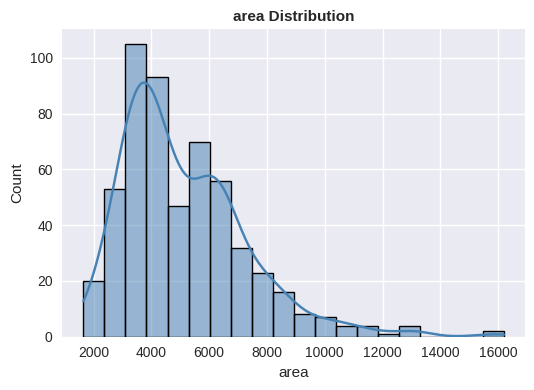

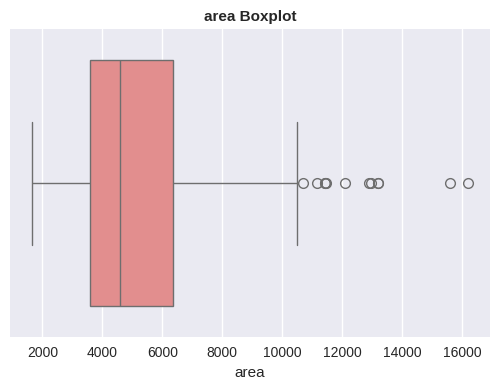

In [10]:
# ============================
# 8. Visualizing Numerical Features
# ============================

print("\n" + "\033[1mNumerical Feature Distributions\033[0m".center(100))

plots_per_row = 3
rows = math.ceil(len(num_features) / plots_per_row)

# --- Histogram + KDE for each numerical feature ---
plt.figure(figsize=(15, 4 * rows))
for idx, col in enumerate(num_features, 1):
    plt.subplot(rows, plots_per_row, idx)
    sns.histplot(
        data=housing_df,
        x=col,
        bins=20,
        kde=True,
        color="steelblue",
        edgecolor="black",
        linewidth=1
    )
    plt.title(f"{col} Distribution", fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()

# --- Boxplots to detect outliers ---
plt.figure(figsize=(15, 4 * rows))
for idx, col in enumerate(num_features, 1):
    plt.subplot(rows, plots_per_row, idx)
    sns.boxplot(
        data=housing_df,
        x=col,
        color="lightcoral"
    )
    plt.title(f"{col} Boxplot", fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()



Pairwise Relationships Between Features


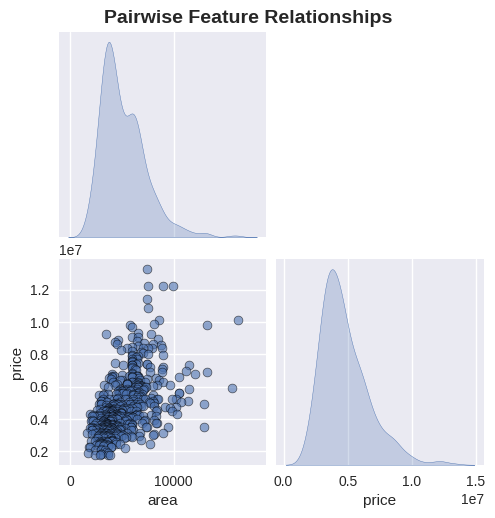

In [11]:
# ==============================
# 9. Pairwise Feature Relationships
# ============================

print("\n\033[1mPairwise Relationships Between Features\033[0m")

# To avoid overcrowding, select a subset of numerical features
selected_features = num_features[:6] + [target_col]  # adjust based on dataset size

# Create pairplot
pairplot = sns.pairplot(
    data=housing_df[selected_features],
    diag_kind="kde",         # KDE plots on diagonal
    corner=True,             # Only lower triangle for clarity
    plot_kws={"alpha": 0.6, "s": 40, "edgecolor": "k"}
)

# Add an overall title
pairplot.fig.suptitle("Pairwise Feature Relationships", y=1.02, fontsize=14, fontweight="bold")
plt.show()


In [12]:
# ============================
# 10. Handling Duplicate Rows
# ============================

initial_shape = raw_df.shape
housing_df = housing_df.drop_duplicates().reset_index(drop=True)
final_shape = housing_df.shape

# Check if duplicates were removed
if initial_shape == final_shape:
    print("\n\033[1mInference:\033[0m No duplicate records found in the dataset.")
else:
    removed = initial_shape[0] - final_shape[0]
    print(f"\n\033[1mInference:\033[0m Removed {removed} duplicate rows from the dataset.")
    print(f"→ New Dataset Shape: {final_shape}")



Inference: No duplicate records found in the dataset.


In [13]:
# ============================
# 11. Missing Values Check
# ============================

print("\n\033[1mChecking for Missing Values in Dataset\033[0m")

# Create a summary DataFrame with null counts and percentage
null_summary = (
    housing_df.isnull()
    .sum()
    .reset_index()
    .rename(columns={"index": "Feature", 0: "Missing Values"})
)

null_summary["% of Total"] = (null_summary["Missing Values"] / housing_df.shape[0] * 100).round(2)

# Sort features by missing values (descending)
null_summary = null_summary.sort_values(by="Missing Values", ascending=False).reset_index(drop=True)

display(null_summary)



Checking for Missing Values in Dataset


,Feature,Missing Values,% of Total
0,price,0,0.0
1,area,0,0.0
2,bedrooms,0,0.0
3,bathrooms,0,0.0
4,stories,0,0.0
5,mainroad,0,0.0
6,guestroom,0,0.0
7,basement,0,0.0
8,hotwaterheating,0,0.0
9,airconditioning,0,0.0


In [14]:
# ============================
# 12. Encoding Categorical Features
# ============================

print("\n\033[1mConverting Categorical Features to Numeric\033[0m")

# Copy dataset to avoid overwriting
encoded_df = housing_df.copy()

# Identify categorical features with no missing values
no_missing_cat = [col for col in cat_features if col not in null_summary[null_summary["% of Total"] != 0]["Feature"].values]

# One-Hot / Dummy Encoding
one_hot_done = False
dummy_done = False

for col in no_missing_cat:
    n_unique = encoded_df[col].nunique()

    # Binary features → One-Hot Encoding
    if n_unique == 2:
        if not one_hot_done:
            print("\n\033[1mApplying One-Hot Encoding on binary features:\033[0m")
            one_hot_done = True
        print(f"→ {col}")
        encoded_df[col] = pd.get_dummies(encoded_df[col], drop_first=True, prefix=col)

    # Categorical features with 3–16 unique values → Dummy Encoding
    elif 2 < n_unique <= 16:
        if not dummy_done:
            print("\n\033[1mApplying Dummy Encoding on multi-class features:\033[0m")
            dummy_done = True
        print(f"→ {col}")
        dummies = pd.get_dummies(encoded_df[col], drop_first=True, prefix=col)
        encoded_df = pd.concat([encoded_df.drop(col, axis=1), dummies], axis=1)

print(f"\n\033[1mDataset shape after encoding:\033[0m {encoded_df.shape}")



Converting Categorical Features to Numeric

Applying One-Hot Encoding on binary features:
→ hotwaterheating
→ basement
→ guestroom
→ mainroad
→ prefarea
→ airconditioning

Applying Dummy Encoding on multi-class features:
→ furnishingstatus
→ bathrooms
→ stories
→ parking
→ bedrooms

Dataset shape after encoding: (545, 24)


In [15]:
# ============================
# 13. Outlier Removal using IQR
# ============================

print("\n\033[1mRemoving Outliers from Numerical Features\033[0m")

# Copy encoded dataset to preserve original
clean_df = encoded_df.copy()

# Use numerical features only for outlier detection
for col in num_features:
    Q1 = clean_df[col].quantile(0.25)
    Q3 = clean_df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Keep only rows within 1.5*IQR range
    clean_df = clean_df[(clean_df[col] >= Q1 - 1.5 * IQR) & (clean_df[col] <= Q3 + 1.5 * IQR)]
    clean_df = clean_df.reset_index(drop=True)

# Display first few rows after outlier removal
display(clean_df.head())

# Print dataset size before and after outlier removal
print(f"\n\033[1mInference:\033[0m")
print(f"→ Before outlier removal: {encoded_df.shape[0]} samples")
print(f"→ After outlier removal: {clean_df.shape[0]} samples")



Removing Outliers from Numerical Features


,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,True,False,False,False,True,True,False,False,...,True,False,False,True,False,False,False,True,False,False
1,12250000,8960,True,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,12250000,9960,True,False,True,False,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
3,12215000,7500,True,False,True,False,True,True,False,False,...,False,False,False,False,True,False,False,True,False,False
4,11410000,7420,True,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False



Inference:
→ Before outlier removal: 545 samples
→ After outlier removal: 533 samples



Final Dataset After Preprocessing


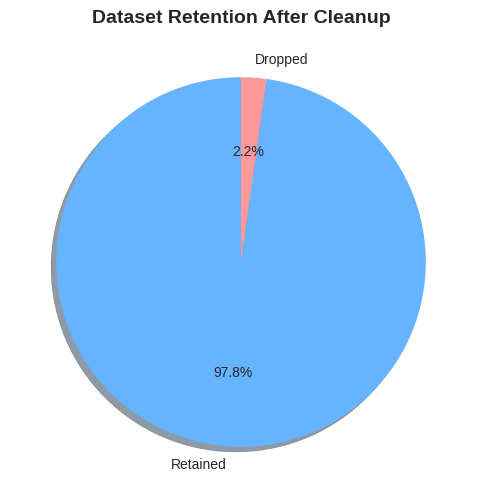


Inference:
→ Total samples dropped: 12
→ Total samples retained: 533 (97.8% of original dataset)


In [16]:
# ============================
# 14. Final Dataset Overview
# ============================

print("\n\033[1mFinal Dataset After Preprocessing\033[0m")

# Copy cleaned dataset and clean column names
final_df = clean_df.copy()
final_df.columns = [col.replace("-", "_") for col in final_df.columns]

# Plot pie chart showing retained vs dropped samples
retained = final_df.shape[0]
dropped = raw_df.shape[0] - retained

plt.figure(figsize=(6,6))
plt.pie(
    [retained, dropped],
    labels=["Retained", "Dropped"],
    autopct="%1.1f%%",
    startangle=90,
    shadow=True,
    colors=["#66b3ff", "#ff9999"]
)
plt.title("Dataset Retention After Cleanup", fontsize=14, fontweight="bold")
plt.show()

# Print summary
print(f"\n\033[1mInference:\033[0m")
print(f"→ Total samples dropped: {dropped}")
print(f"→ Total samples retained: {retained} ({round(retained*100/raw_df.shape[0],2)}% of original dataset)")


In [17]:
# ============================
# 15. Data Manipulation: Train-Test Split
# ============================

print("\n\033[1mSplitting Dataset into Training and Testing Sets\033[0m")

# Clean column names (replace spaces with underscores)
final_df.columns = [col.strip().replace(" ", "_") for col in final_df.columns]

# Separate features and target
X = final_df.drop(target_col, axis=1)
y = final_df[target_col]

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=100
)

# Reset indices for training set
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Print dataset shapes
print(f"\n\033[1mDataset Shapes:\033[0m")
print(f"→ Original Set: Features = {X.shape}, Target = {y.shape}")
print(f"→ Training Set: Features = {X_train.shape}, Target = {y_train.shape}")
print(f"→ Testing Set : Features = {X_test.shape}, Target = {y_test.shape}")



Splitting Dataset into Training and Testing Sets

Dataset Shapes:
→ Original Set: Features = (533, 23), Target = (533,)
→ Training Set: Features = (426, 23), Target = (426,)
→ Testing Set : Features = (107, 23), Target = (107,)


In [18]:
# ============================
# 16. Feature Scaling (Standardization)
# ===========================

print("\n\033[1mStandardization of Features\033[0m")

# Initialize StandardScaler
scaler = StandardScaler()

# --- Scale Training Set ---
print("\n" + "\033[1mTraining Set Standardization\033[0m".center(100))
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
display(X_train_scaled.describe())

# --- Scale Testing Set ---
print("\n" + "\033[1mTesting Set Standardization\033[0m".center(100))
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
display(X_test_scaled.describe())



Standardization of Features

                                Training Set Standardization                                


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,...,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02
mean,-6.463270e-17,9.799152e-17,-2.501911e-17,1.250956e-17,-3.544374e-17,1.355202e-17,-2.918896e-17,-1.876433e-17,-3.752867e-17,2.084926e-17,...,2.501911e-17,1.667941e-17,-1.459448e-17,-1.355202e-17,8.339703e-17,-8.756689e-17,2.501911e-17,1.667941e-17,8.339703e-17,-4.169852e-18
std,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,...,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00
min,-1.797874e+00,-2.335497e+00,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
25%,-7.487891e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
50%,-2.551019e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
75%,6.110159e-01,4.281744e-01,-4.659859e-01,1.322266e+00,-2.038745e-01,1.468181e+00,-5.393599e-01,1.186077e+00,1.429286e+00,1.150196e+00,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,1.674387e+00,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
max,2.992840e+00,4.281744e-01,2.145988e+00,1.322266e+00,4.904979e+00,1.468181e+00,1.854050e+00,1.186077e+00,1.429286e+00,1.726647e+00,...,3.699953e+00,3.633180e+00,1.829464e+00,2.032863e+00,6.806859e+00,1.674387e+00,9.275031e-01,2.180999e+00,6.806859e+00,2.061553e+01



                                Testing Set Standardization                                 


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,1.070000e+02,107.000000
mean,0.025531,0.144059,0.022233,-0.154083,0.130350,0.001839,0.042216,0.029248,0.016627,-0.040418,...,0.063671,0.126559,0.008549,-0.019996,0.048055,-0.130171,0.121488,0.010192,-1.469106e-01,0.144615
std,1.021135,0.843283,1.023054,0.947331,1.269193,1.005431,1.031339,1.009305,1.010644,0.980290,...,1.107146,1.192583,1.010164,0.988902,1.153328,0.922384,0.987957,1.013435,1.952033e-16,1.997668
min,-1.635477,-2.335497,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
25%,-0.809959,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
50%,-0.200970,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
75%,0.762586,0.428174,-0.465986,1.322266,-0.203874,1.468181,-0.539360,1.186077,1.429286,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
max,2.867794,0.428174,2.145988,1.322266,4.904979,1.468181,1.854050,1.186077,1.429286,1.726647,...,3.699953,3.633180,1.829464,2.032863,6.806859,1.674387,0.927503,2.180999,-1.469106e-01,20.615528



                               Correlation Matrix of Features                               


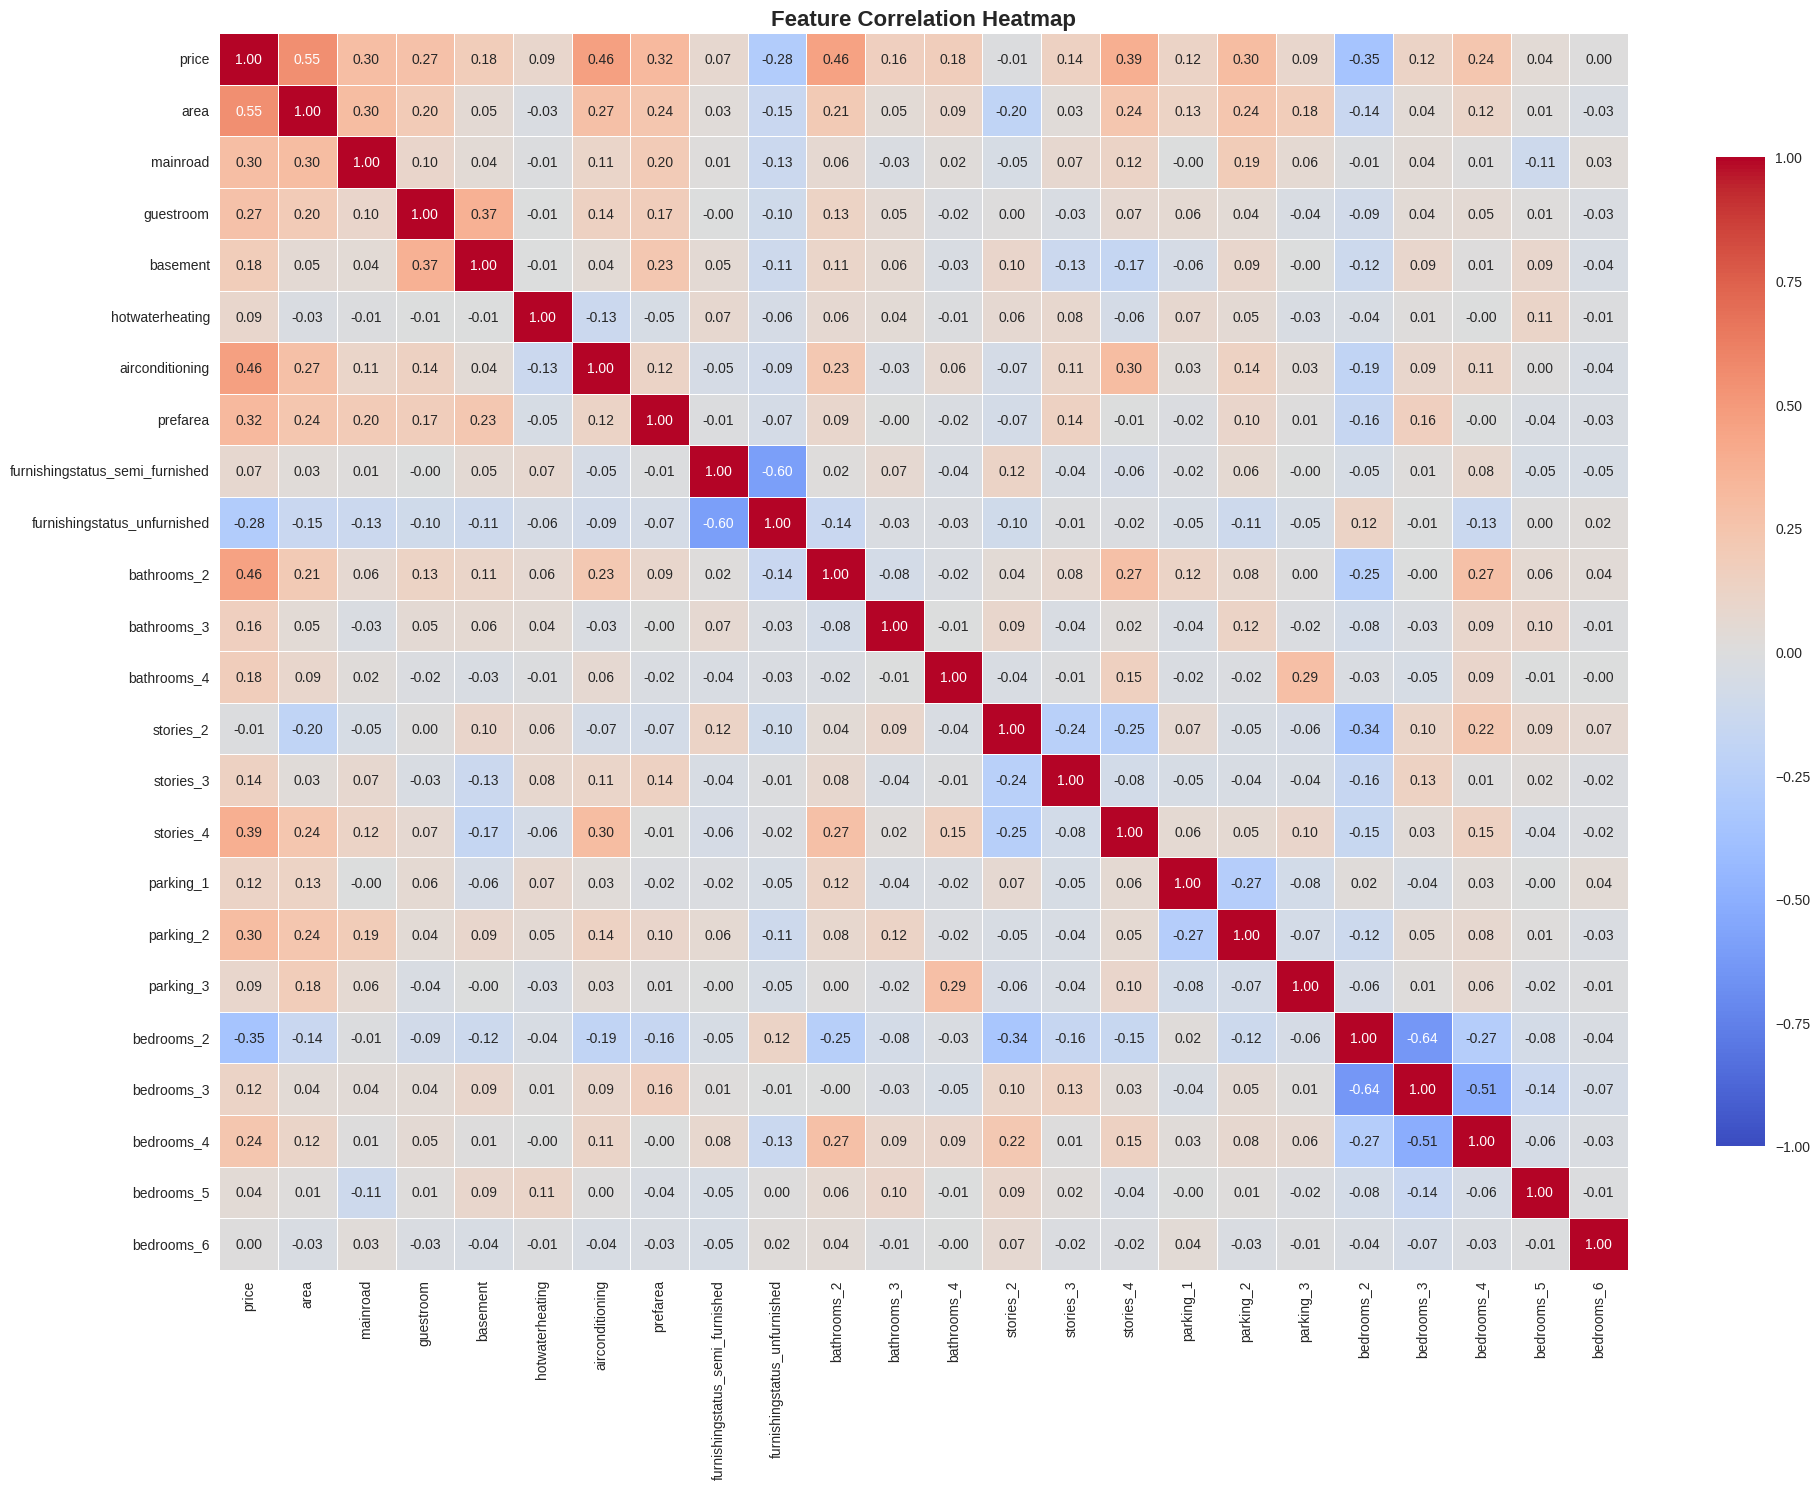

In [19]:
# ============================
# 17. Feature Selection / Correlation Analysis
# ============================

print("\n" + "\033[1mCorrelation Matrix of Features\033[0m".center(100))

# Compute correlation matrix
corr_matrix = final_df.corr()

# Plot heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Heatmap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


In [20]:
# ============================
# 18. Predictive Modeling: Linear Regression (Statsmodels)
# ============================

print("\n\033[1mLinear Regression Model using Statsmodels\033[0m")

# Combine standardized training features and target
train_data = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)

# Prepare formula for OLS regression
feature_formula = " + ".join(X_train_scaled.columns)
ols_formula = f"{target_col} ~ {feature_formula}"

# Fit the model
ols_model = api.ols(formula=ols_formula, data=train_data).fit()

# Display model summary
display(ols_model.summary())



Linear Regression Model using Statsmodels


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     36.96
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           2.06e-84
Time:                        04:34:05   Log-Likelihood:                -6509.2
No. Observations:                 426   AIC:                         1.307e+04
Df Residuals:                     402   BIC:                         1.316e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        4.717e+06   5.22e+04     90.378      0.000    4.61e+06    4.82e+06
area                             4.356e+05   6.41e+04      6.799      0.000     3.1e+05    5.62e+05
mainroad                         1.785e+05   5.77e+04      3.092      0.002     6.5e+04    2.92e+05
guestroom                        1.197e+05   5.78e+04      2.071      0.039    6082.572    2.33e+05
basement                         1.712e+05   6.15e+04      2.784      0.006    5.03e+04    2.92e+05
hotwaterheating                  2.006e+05   5.48e+04      3.662      0.000    9.29e+04    3.08e+05
airconditioning                  3.635e+05   5.89e+04      6.168      0.000    2.48e+05    4.79e+05
prefarea                         2.711e+05   5.75e+04      4.711      0.000    1.58e+05    3.84e+05
furnishingstatus_semi_furnished  1.509e+04   6.71e+04      0.225      0.822   -1.17e+05    1.47e+05
furnishingstatus_unfurnished    -1.688e+05   6.78e+04     -2.489      0.013   -3.02e+05   -3.55e+04
bathrooms_2                      3.722e+05   5.98e+04      6.224      0.000    2.55e+05     4.9e+05
bathrooms_3                      1.886e+05    5.4e+04      3.492      0.001    8.24e+04    2.95e+05
bathrooms_4                      2.801e+05   5.68e+04      4.934      0.000    1.69e+05    3.92e+05
stories_2                        1.341e+05   6.97e+04      1.923      0.055   -2986.085    2.71e+05
stories_3                        2.289e+05   6.13e+04      3.735      0.000    1.08e+05    3.49e+05
stories_4                        3.725e+05   6.46e+04      5.764      0.000    2.45e+05       5e+05
parking_1                         1.67e+05   5.78e+04      2.887      0.004    5.33e+04    2.81e+05
parking_2                        2.781e+05   5.97e+04      4.662      0.000    1.61e+05    3.95e+05
parking_3                       -5.772e+04   5.72e+04     -1.009      0.314    -1.7e+05    5.47e+04
bedrooms_2                      -3.385e+04    4.8e+05     -0.070      0.944   -9.78e+05    9.11e+05
bedrooms_3                       1.077e+05   5.45e+05      0.197      0.844   -9.64e+05    1.18e+06
bedrooms_4                       1.215e+05   4.18e+05      0.291      0.771      -7e+05    9.43e+05
bedrooms_5                       3.933e+04   1.66e+05      0.237      0.812   -2.86e+05    3.65e+05
bedrooms_6                       8.462e+04   7.49e+04      1.130      0.259   -6.26e+04    2.32e+05
==============================================================================
Omnibus:                       96.025   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.474
Skew:                           1.058   Prob(JB):                     2.51e-60
Kurtosis:                       6.315   Cond. No.                  

In [21]:
# ============================
# 19. Final Model Selection & Prediction
# ============================

# Using Multiple Linear Regression as final model
final_model = LinearRegression()
final_model.fit(X_train_scaled, y_train)

# Predictions
train_pred = final_model.predict(X_train_scaled)
test_pred = final_model.predict(X_test_scaled)

# Display evaluation metrics
print("\033[1mFinal Model Evaluation - Multiple Linear Regression\033[0m\n")
print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Testing RMSE : {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Training R²  : {r2_score(y_train, train_pred):.4f}")
print(f"Testing R²   : {r2_score(y_test, test_pred):.4f}")


Final Model Evaluation - Multiple Linear Regression

Training RMSE: 1046377.3975
Testing RMSE : 1041399.1671
Training R²  : 0.6789
Testing R²   : 0.6867


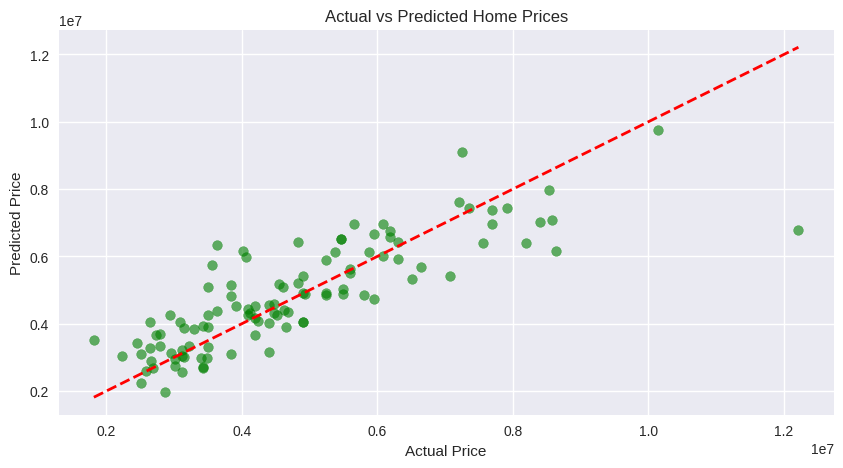

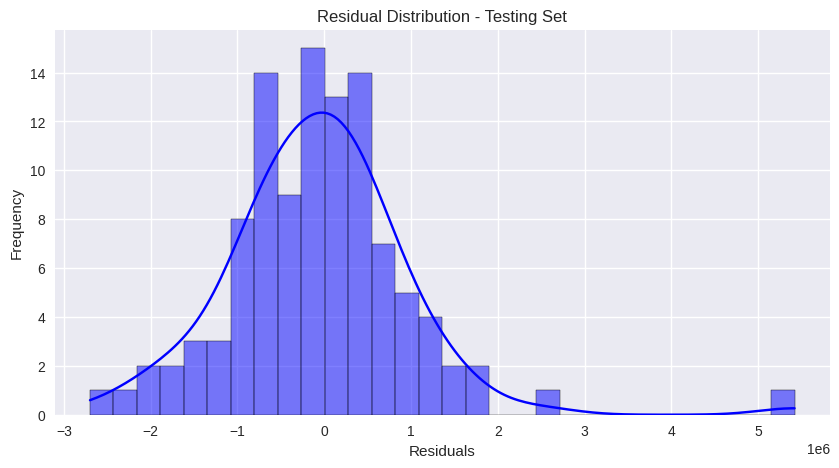

In [22]:
# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(10,5))
plt.scatter(y_test, test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Home Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

# Residual Distribution
plt.figure(figsize=(10,5))
sns.histplot(y_test - test_pred, kde=True, color='blue', bins=30)
plt.title('Residual Distribution - Testing Set')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
